# Who will win the 1st round of Paris 2020 elections in each district?
### Predicting French elections with Python and a hierarchical Bayesian model
*By [Alex ANDORRA](https://twitter.com/alex_andorra) -- Last updated March 13, 2020*

This [Voilà](https://voila.readthedocs.io/en/stable/index.html) app presents the results of a Bayesian hierarchical model that looks at all previous elections and tries to predict them based on three main sources of information: the polls, the unemployment rate in Paris and the type of election (local, presidential, legislative...). The nice thing is that the model gives us estimates for each party, in each district of Paris -- which is, to the best of my knowledge, the first one to do that and with this depth of data. 

This page focuses on analyzing and plotting the results. So, you don't have to _understand_ the model to understand what it's telling us. But, if you're curious about it, please go ahead and [check out the code and data](https://github.com/AlexAndorra/pollsposition_models) I used to get there!

Now, I could analyze the most important parameters in the model, what they mean and how this relates to the political science of Paris. But I'm not gonna do that -- at least not in a first draft of this analysis. As I want this notebook to be accessible to not-so-technical folks, I'll focus on vizualisations -- and as this model has hundreds of dimensions and parameters, I think it's also better than staring at a table of coefficients.

So, without further ado, let's look at our first plot!

In [41]:
import arviz as az
import bokeh.plotting as bkp
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, GeoJSONDataSource, HoverTool, Legend, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer, cividis
from bokeh.transform import linear_cmap

#PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES = ["farleft", "left", "green", "center", "right", "other"]
Ndistricts = 17
WINNER_COLORS = {
    "Left": brewer["PuRd"][3][1],
    "Center": brewer["Oranges"][3][1],
    "Right": brewer["Blues"][3][1],
}

In [42]:
az.style.use("arviz-darkgrid")
output_notebook()

Loading BokehJS ...

In [3]:
results = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)
results = results[results.date == "2020-03-15"]

In [39]:
share_est = az.from_netcdf("oos_data/share_est_nofr.nc").posterior.stack(sample=("chain", "draw"))["x"]
share_mean = share_est.mean(dim="sample")

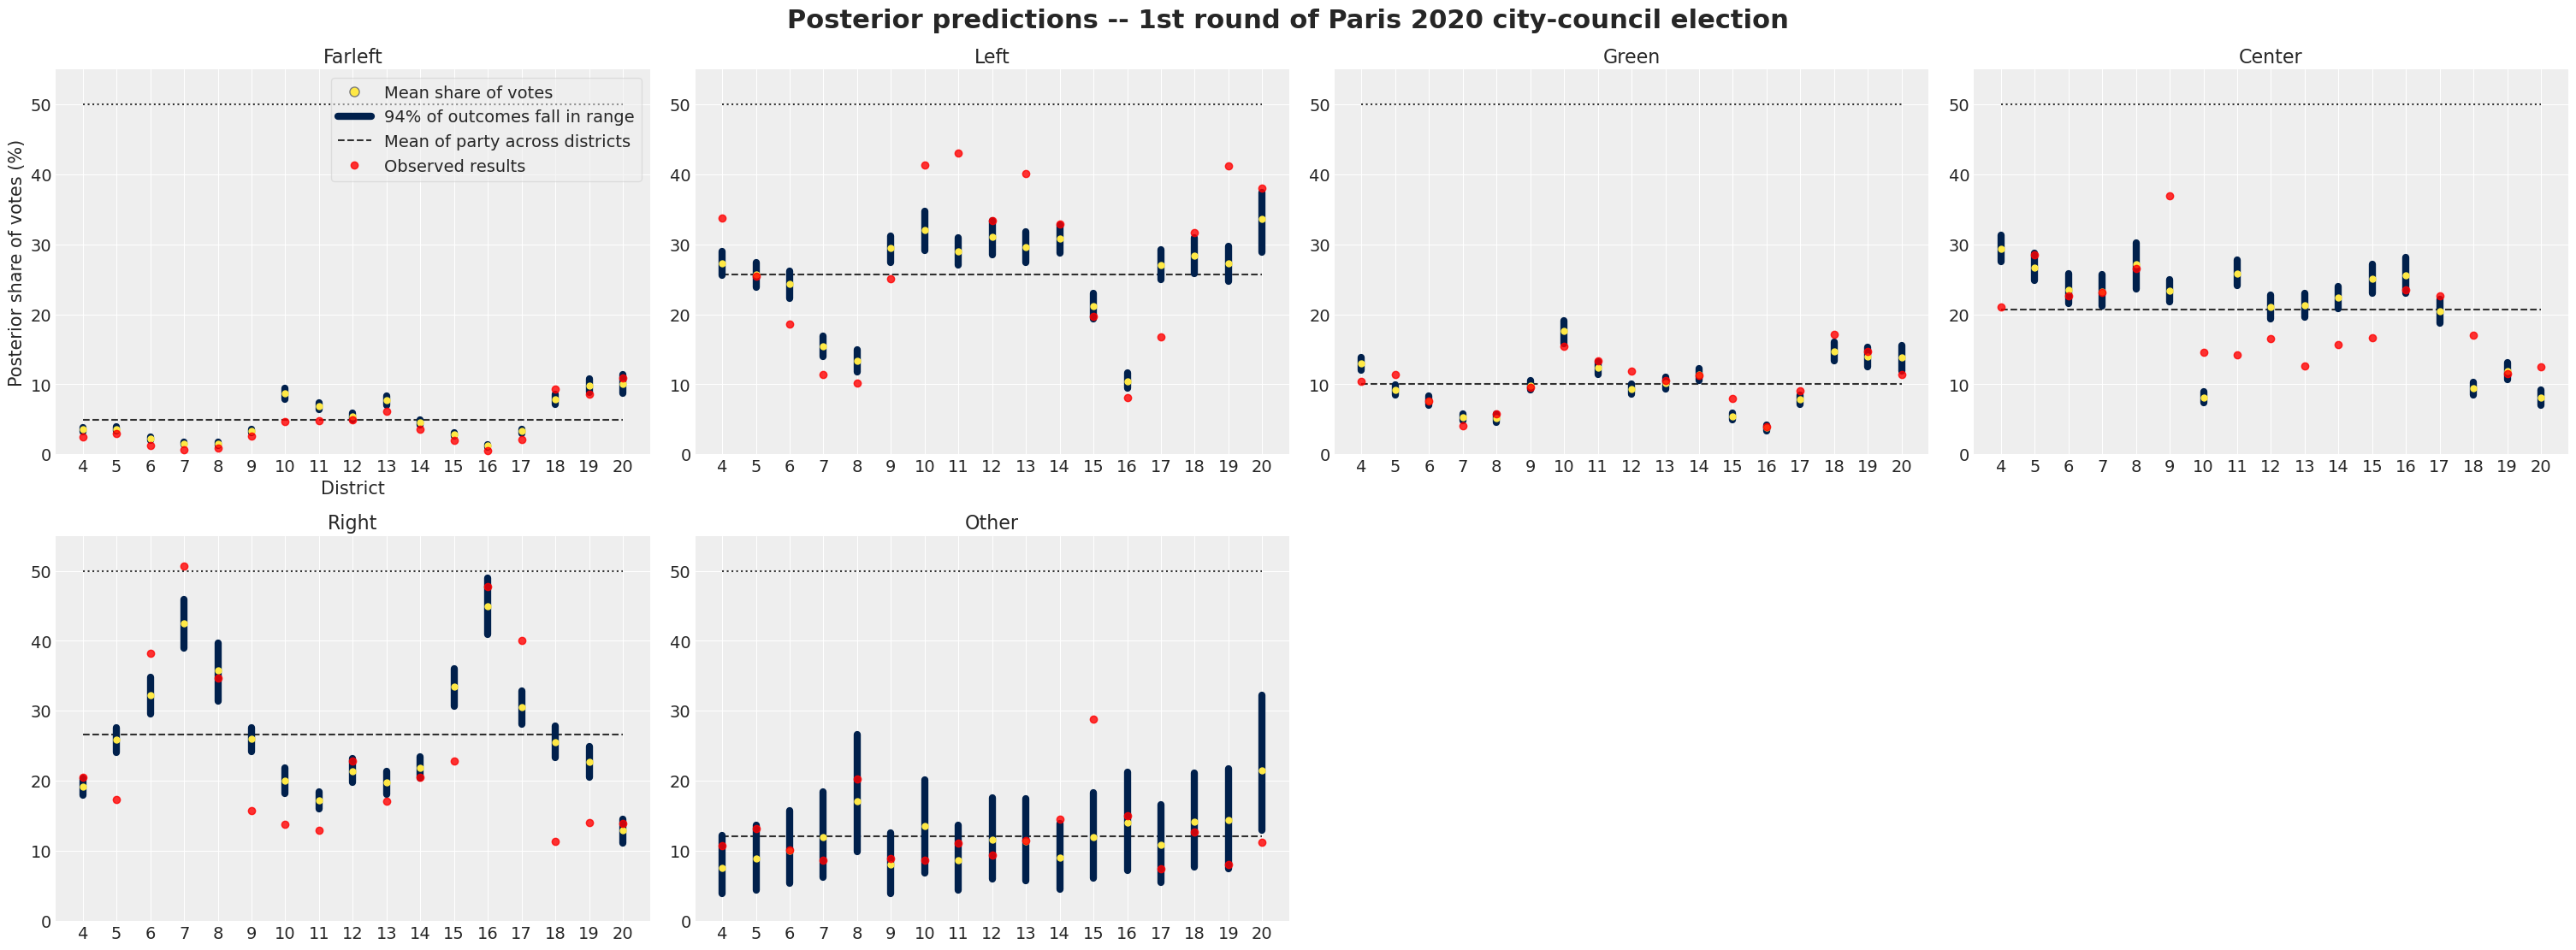

In [43]:
fig, axes = plt.subplots(2, 4, figsize=(30, 11), constrained_layout=True)
axes = np.ravel(axes)
axes[-1].remove()
axes[-2].remove()
for party, ax in zip(PARTIES, axes):
    try:
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hdi(share_est, input_core_dims=[["sample"]], coords={"party_complete": party})["x"].T,
            color=cividis(3)[0],
            lw=6,
        )
        ax.plot(
            np.arange(Ndistricts), share_mean.sel(party_complete=party), "o", color=cividis(3)[2], ms=5,
        )
        ax.plot(
            np.arange(Ndistricts), (results[party] / results.N) * 100, "o", ms=6, color="red", alpha=0.8
        )
        ax.hlines(
            share_est.mean(dim=("district", "sample")).sel(party_complete=party),
            np.arange(Ndistricts)[0], np.arange(Ndistricts)[-1],
            "k", "--", lw=1.5, alpha=0.8
        )
        ax.hlines(
            50, np.arange(Ndistricts)[0], np.arange(Ndistricts)[-1], "k", ":", lw=1.5, alpha=0.8
        )
        ax.set_xticks(np.arange(Ndistricts))
        ax.set_xticklabels(np.arange(4, 21))
        ax.set_title(f"{party.title()}")
        ax.set_ylim([-0.05, 55.0])
        if party == "farleft":
            ax.set_xlabel("District")
            ax.set_ylabel("Posterior share of votes (%)")
            ax.plot(
                [],
                "o",
                markeredgecolor=cividis(3)[1],
                markeredgewidth=1,
                color=cividis(3)[2],
                ms=8,
                label="Mean share of votes",
            )
            ax.plot(
                [], label="94% of outcomes fall in range", color=cividis(2)[0], lw=6
            )
            ax.plot(
                [],
                "k--",
                lw=1.5, 
                alpha=0.8,
                label="Mean of party across districts",
            )
            ax.plot(
                [],
                "o",
                ms=6, 
                color="red", 
                alpha=0.8,
                label="Observed results",
            )
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Posterior predictions -- 1st round of Paris 2020 city-council election",
    size=22,
    weight="bold",
);

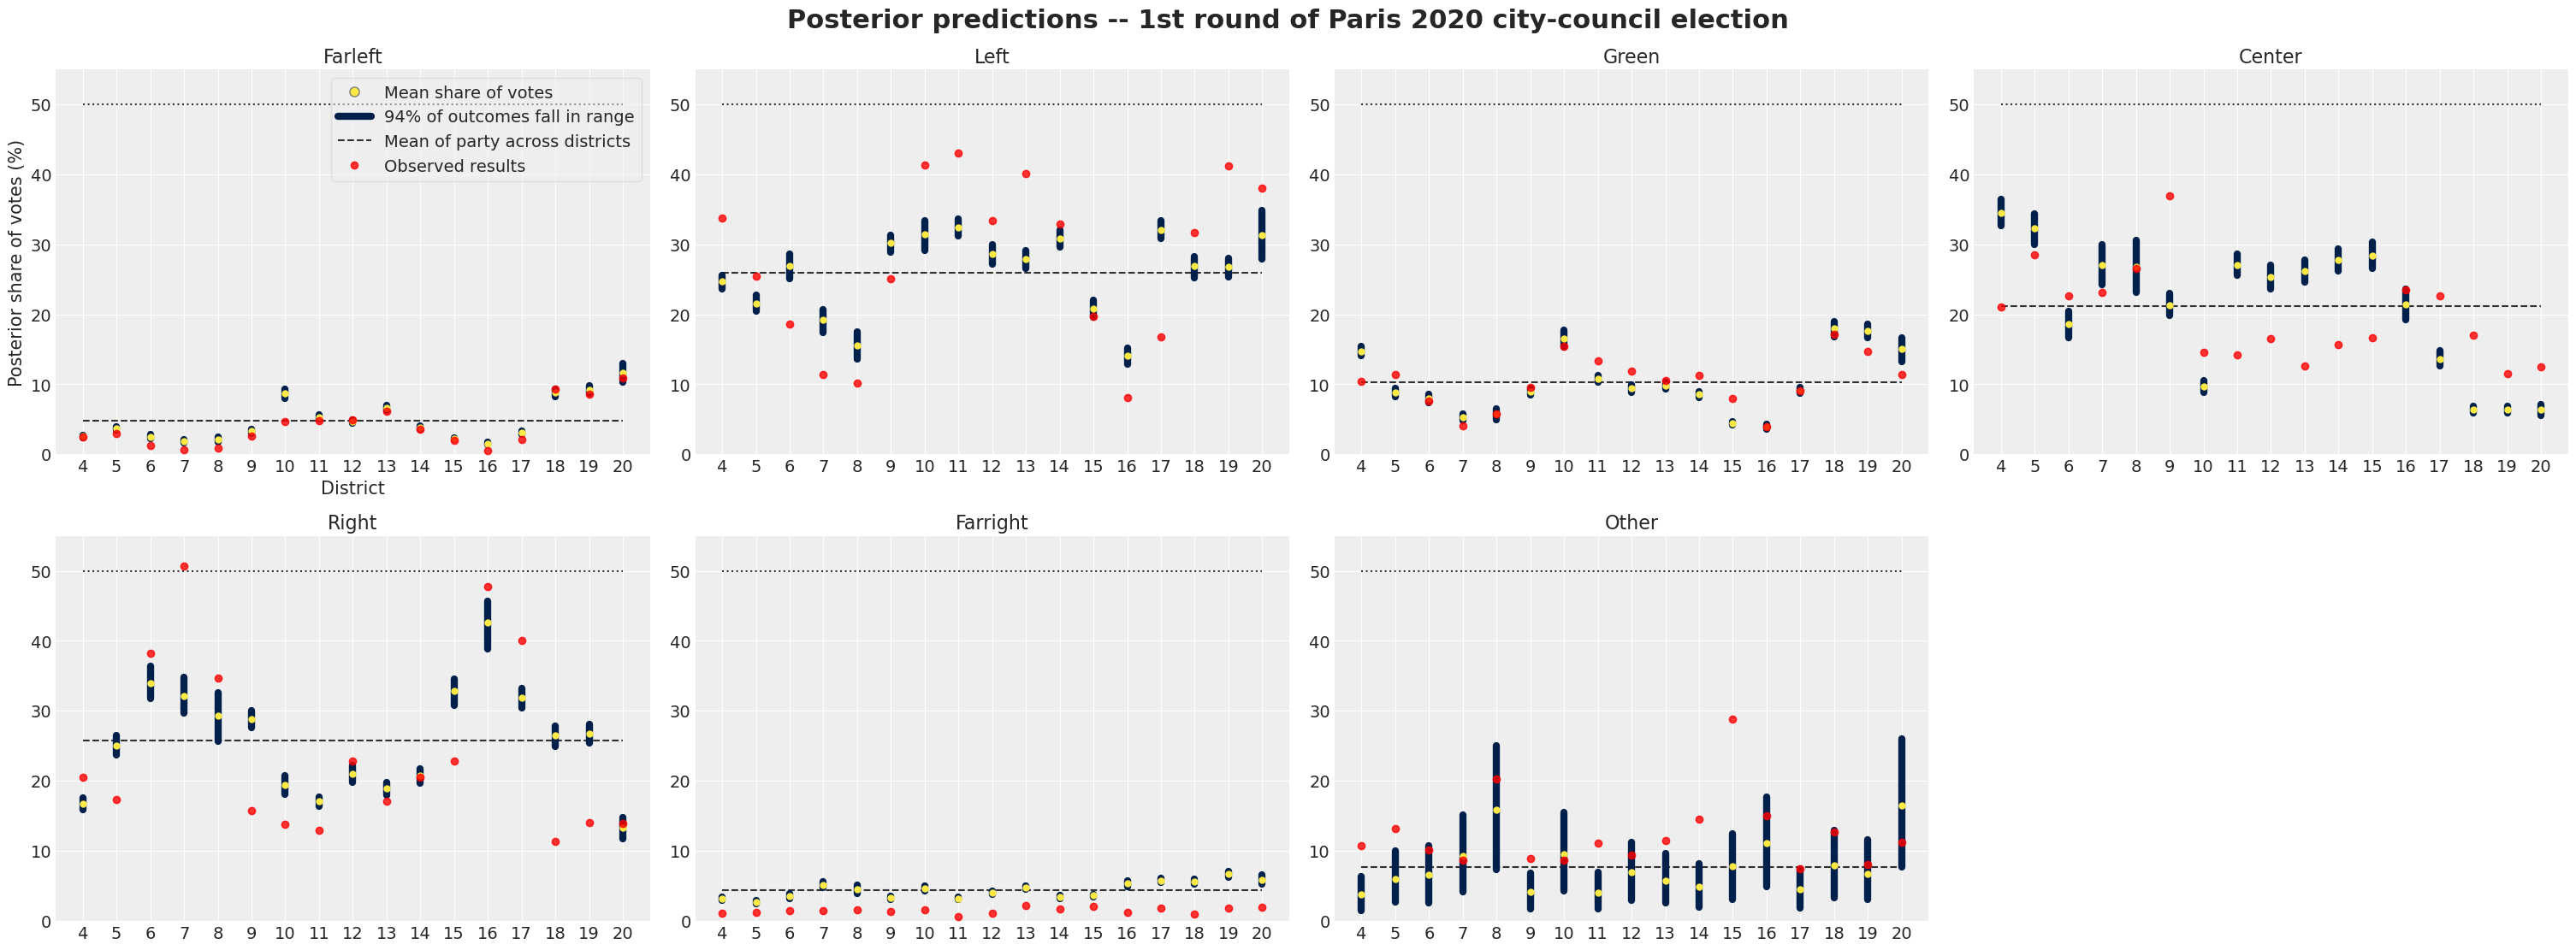

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(30, 11), constrained_layout=True)
axes = np.ravel(axes)
axes[-1].remove()
for party, ax in zip(PARTIES, axes):
    try:
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hdi(share_est, input_core_dims=[["sample"]], coords={"party_complete": party})["x"].T,
            color=cividis(3)[0],
            lw=6,
        )
        ax.plot(
            np.arange(Ndistricts), share_mean.sel(party_complete=party), "o", color=cividis(3)[2], ms=5,
        )
        ax.plot(
            np.arange(Ndistricts), (results[party] / results.N) * 100, "o", ms=6, color="red", alpha=0.8
        )
        ax.hlines(
            share_est.mean(dim=("district", "sample")).sel(party_complete=party),
            np.arange(Ndistricts)[0], np.arange(Ndistricts)[-1],
            "k", "--", lw=1.5, alpha=0.8
        )
        ax.hlines(
            50, np.arange(Ndistricts)[0], np.arange(Ndistricts)[-1], "k", ":", lw=1.5, alpha=0.8
        )
        ax.set_xticks(np.arange(Ndistricts))
        ax.set_xticklabels(np.arange(4, 21))
        ax.set_title(f"{party.title()}")
        ax.set_ylim([-0.05, 55.0])
        if party == "farleft":
            ax.set_xlabel("District")
            ax.set_ylabel("Posterior share of votes (%)")
            ax.plot(
                [],
                "o",
                markeredgecolor=cividis(3)[1],
                markeredgewidth=1,
                color=cividis(3)[2],
                ms=8,
                label="Mean share of votes",
            )
            ax.plot(
                [], label="94% of outcomes fall in range", color=cividis(2)[0], lw=6
            )
            ax.plot(
                [],
                "k--",
                lw=1.5, 
                alpha=0.8,
                label="Mean of party across districts",
            )
            ax.plot(
                [],
                "o",
                ms=6, 
                color="red", 
                alpha=0.8,
                label="Observed results",
            )
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Posterior predictions -- 1st round of Paris 2020 city-council election",
    size=22,
    weight="bold",
)
plt.savefig("PPC.png");

This graph displays the model's estimation of each party's strength in each district. The yellow points are the mean estimates, and the blue bars are the 94% compatibility interval -- in the small world of the model, there is a 94% chance that the true result will fall in this range; of course, a model is a reduction of reality, so there usually is more uncertainty than just the one the model tells us about. But it should be a good rule of thumb (if I did a good job!) and it allows us to compare the uncertainty across districts and parties.

**We already see the big favorites: left, center and right, by descending order. The centrist party is the one with the biggest uncertainty**. I think this is mostly due to the fact that this party was a semi-fringe one before 2017 and Emmanuel Macron. So, we don't have a lot of data to estimate its chances -- just think that for the last city-council elections, in 2014, the centrist party was so weak that they didn't compete; and now, it's the president's party, which accounts for a sizeable share of the electorate, especially in Paris.

There are other interesting observations to make:

- **The center party's support is quite uniform, while the right and left parties' tends to be volatile across districts**. Except in the last three districts (18, 19, 20 -- the most eastwards and left-oriented districts), the centrist party's support is quite homogeneous in the capital -- between 20% and 30% on average. On the contrary, the suport for the traditional left (PS) and right parties (LR) is much more volatile across districts: while some districts _really_ love the Republicans (mostly the 7th, 8th and 16th districts, historically Paris's most rich and convervatives districts), other really don't like them (mainly the Eastern parts of the city, as you'll see in the map below). My assumption is that, as these parties have been around for more than 50 years, people's feelings about them have crystalized and polarized -- they are really sure about whether or not they love these parties. Conversely, Macron's party is really young, so most Parisians are still unsure about their feelings for it -- hence a more uniform support, where it's not really hated, but not really loved either.

- **The left and right parties seem to mirror each other**: within each district, when one party's support is high, the other's tend to be low -- stattiscally speaking, they are negatively correlated. This is not surprising, as these two parties used to be the only big parties and cut the society in half -- you couldn't support both the right and the left; you _had_ to pick a side. Even though these parties' current power is nowhere near what it used to be now that the center and far right parties dominate the national political landscape, this polarization still seems to be active in the capital.

- Speaking of the national political landscape, it's striking to see that it is not reflected in the current race: the two main forces in this race aren't the center and far right parties, but the two traditional parties -- Republicans and Socialists. Let's not read too much into it for coming national elections though: **city-council elections are mostly influenced by local dynamics, and Paris is no exception**. In 2017 and 2019, the centrist party was much stronger and Paris was much closer to the national landscape -- my prior is that it will be the same thing for coming national elections, making the city-council election an exception, as it often is.

- **The extreme parties (far right and far left) are particularly weak**. This is common in Paris, and also a reason why Paris rarely represents the national political landscape: the mainstream, liberal parties (left, center, right) tend to overperform their national support there, while the populist, extreme parties (far left and far right) unsually underperfom their national scores -- although the far left party has sizable support in districts 18, 19 and 20, which are traditionally the most leftwards in the city.

Now, let's plot the model's expectations on a map of Paris! This will complement and highlight the observations we made above. This is done by the code below, in big part thanks to Grégoire David and [his awesome open-source project, france-geojson](https://github.com/gregoiredavid/france-geojson), where I found the geographic shapes of Paris.

In [29]:
paris_shape = gpd.read_file("oos_data/paris_shape.geojson")
geosource = GeoJSONDataSource(geojson=paris_shape.to_json())

In [30]:
p = bkp.figure(
    title="Predictions by district -- 1st round of Paris 2020 city-council election",
    align="center",
    plot_height=350,
    plot_width=600,
    sizing_mode="scale_both",
    title_location="above",
    tools="",
    toolbar_location=None,
)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.axis.visible = False
p.outline_line_color = None
p.title.align = "center"
p.title.text_font_size = "1.4rem"

palette = brewer["Greys"][7][::-1]
color_mapper = LinearColorMapper(palette=palette, low=0, high=75)
# custom tick labels for color bar:
tick_labels = {
    "0": "0",
    "10": "15",
    "20": "25",
    "30": "35",
    "40": "45",
    "50": "55",
    "60": "65",
    "70": "75+% of votes",
}
color_bar = ColorBar(
    border_line_color=None,
    color_mapper=color_mapper,
    height=400,
    label_standoff=18,
    major_label_overrides=tick_labels,
    orientation="vertical",
    padding=0,
    title="7 Shades of Grey",
    title_standoff=4,
    width=20,
)
district_shapes = p.patches(
    "xs",
    "ys",
    fill_color="color",
    fill_alpha=1,
    line_color="gray",
    line_width=0.75,
    source=geosource,
)
p.add_tools(
    HoverTool(
        renderers=[district_shapes],
        tooltips=[
            ("", "Paris, District @district"),
            ("Winner", "@winner, with @prob% chance"),
            ("Mean", "@mean{1.1} %"),
            ("94% HPD", "[@low{1.1} - @high{1.1}] % of votes"),
        ],
    )
)

for winner in paris_shape.winner.unique():
    p.square(x=[], y=[], line_color=None, fill_color=WINNER_COLORS[winner], legend_label=winner)
p.legend.border_line_width = 0
p.legend.glyph_height = 33
p.legend.glyph_width = 33
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
p.legend.title = "Winning Party"
p.add_layout(color_bar)
show(p)

Lots of information on this map! You get a lot of detailed information when hovering over the districts: the expected winner of the district and its associated probability; the mean vote share; the 94% compatibility interval of vote shares. 

The color of each district indicates who the projected winner is -- here, only the right (blue), center (orange) and left (pink) parties are expected to win districts. In addition, each party's color is declined in shades. As indicated by the color bar to the right, the darker the color, the bigger the expected vote share for the party in the district. The center party is displayed in only one shade, which means its support is about the same in the districts it's expected to win. On the contrary, the Socialist party is stronger on the East side of Paris -- where it's mostly a huge favorite -- than in the center -- where its probabilities of winning are much slimmer and closer to the centrist party. 

We recover the observations we made before: leftwards strongholds in the Eastern and Northern districts of Paris; a few rightwards strongholds in the West of Paris; a uniform support for the centrist party across districts; and local dynamics that defy national dynamics, as the two traditional parties are still strong in the capital, although their support is disparate across districts.

Do you see other trends? Or do you have comments or suggestions? Then [feel free to reach out](https://twitter.com/alex_andorra) -- I'm always happy to get feedback!

_A huge thank you to [Junpeng Lao](https://twitter.com/junpenglao) for his numerous, patient and always relevant modeling advice! I will never thank enough all the [PyMC](https://docs.pymc.io/) and [ArviZ](https://arviz-devs.github.io/arviz/) developers, who work on their free time to give us access to fast, reliable and amazing scientific and computing tools. Finally, I want to thank Alexis Bergès, Bérengère Patault and Simon Bunel for their advice and support when the model wouldn't fit and the only solution seemed to be to throw my laptop out the window._